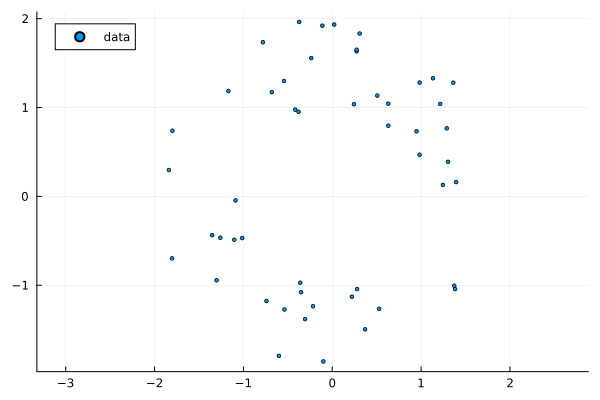

In [4]:
using LinearAlgebra
using Plots
using Ripserer
using CSV
using Distances
using AbstractAlgebra
using AbstractAlgebra
using Oscar
using SparseArrays
using StatsBase

FIELD = 8

function annulus(n, r1=1, r2=2, offset=(0, 0))
    result = Tuple{Float64,Float64}[]
    while length(result) < n
        point = 2 * r2 * rand(2) .- r2
        if r1 < norm(point) < r2
            push!(result, (point[1] + offset[1], point[2] + offset[2]))
        end
    end
    return result
end

data = annulus(50)

x_coords = getindex.(data, 1)
y_coords = getindex.(data, 2)

data_matrix = hcat(x_coords, y_coords)'

distance_matrix = pairwise(Euclidean(), data_matrix);

scatter(data; label="data", markersize=2, aspect_ratio=1)

In [5]:

using SparseArrays

"""
    build_complex_and_boundary_operator(vertices, edges)

Constructs the simplicial complex up to dimension 2 from a graph and computes
the boundary operator matrix D = [∂₁ ∂₂].

A 2-simplex (triangle) is included if and only if its three bounding edges
are all present in the `edges` list.

# Arguments
- `vertices`: An iterable collection of vertex identifiers (e.g., `1:100`).
- `edges`: A `Vector` of 2-element `Tuples` or `Vectors`, e.g., `[(1, 2), (2, 3), ...]`,
  representing the 1-simplices (edges) of the graph.

# Returns
- `D::SparseMatrixCSC{Int, Int}`: The boundary operator matrix.
- `simplex_indices::Dict{Symbol, Any}`: A dictionary containing mappings from
  each simplex to its corresponding index range in the matrix `D`.
  Keys are `:vertices`, `:edges`, and `:triangles`.
"""
function build_complex_and_boundary_operator(vertices, edges)
    # === 1. CANONICALIZE INPUT AND FIND 2-SIMPLICES (TRIANGLES) ===

    # Ensure all edges are in a canonical format (v₁, v₂) where v₁ < v₂
    canonical_edges = Set(sort(collect(e)) |> Tuple for e in edges)

    # Build an adjacency structure for fast neighbor lookups (O(|E|))
    adj = Dict{Int, Set{Int}}(v => Set{Int}() for v in vertices)
    for (u, v) in canonical_edges
        push!(adj[u], v)
        push!(adj[v], u)
    end

    # Find all unique triangles (2-simplices) efficiently (O(Σ deg(v)²))
    # A triangle {u, v, w} exists if (u,v), (v,w), and (u,w) are all edges.
    triangles = Set{NTuple{3, Int}}()
    for u in vertices
        # Iterate over pairs of neighbors of u
        neighbors_of_u = sort(collect(adj[u]))
        for i in 1:length(neighbors_of_u)
            for j in (i+1):length(neighbors_of_u)
                v = neighbors_of_u[i]
                w = neighbors_of_u[j]

                # If v and w are connected, then {u, v, w} is a triangle.
                # We already know (u,v) and (u,w) are edges.
                if w in adj[v] # This is the correct way to check for membership in a Set

                    # Add in sorted order to ensure canonical representation
                    push!(triangles, tuple(sort([u, v, w])...))
                end
            end
        end
    end

    # === 2. CREATE STABLE ORDERING AND INDEX MAPPINGS ===

    # Sort simplices to have a deterministic order for matrix construction
    sorted_vertices = sort(collect(vertices))
    sorted_edges = sort(collect(canonical_edges))
    sorted_triangles = sort(collect(triangles))

    n_verts = length(sorted_vertices)
    n_edges = length(sorted_edges)
    n_triangles = length(sorted_triangles)

    # Dictionaries to map each simplex to its column index in the matrix D
    edge_to_idx = Dict(edge => i + n_verts for (i, edge) in enumerate(sorted_edges))
    triangle_to_idx = Dict(tri => i + n_verts + n_edges for (i, tri) in enumerate(sorted_triangles))

    # === 3. CONSTRUCT THE BOUNDARY OPERATOR MATRIX D ===

    total_dim = n_verts + n_edges + n_triangles
    
    # Use I, J, V format for efficient sparse matrix creation
    I, J, V = Int[], Int[], Int[]

    # Part 1: ∂₁ (Edges -> Vertices)
    # For an edge (u, v), its boundary is ∂(u,v) = v - u
    for (edge, col_idx) in edge_to_idx
        u, v = edge # edge is canonical, so u < v
        # Add -1 for the starting vertex row
        push!(I, u); push!(J, col_idx); push!(V, 1)
        # Add +1 for the ending vertex row
        push!(I, v); push!(J, col_idx); push!(V, -1)
    end

    # Part 2: ∂₂ (Triangles -> Edges)
    # For a triangle (u, v, w), ∂(u,v,w) = (v,w) - (u,w) + (u,v)
    for (triangle, col_idx) in triangle_to_idx
        u, v, w = triangle # triangle is canonical, u < v < w
        
        # Get the row indices for the three bounding edges
        row_idx_vw = edge_to_idx[(v, w)]
        row_idx_uw = edge_to_idx[(u, w)]
        row_idx_uv = edge_to_idx[(u, v)]
        
        # Populate the matrix according to the boundary formula
        push!(I, row_idx_vw); push!(J, col_idx); push!(V, 1)
        push!(I, row_idx_uw); push!(J, col_idx); push!(V, -1)
        push!(I, row_idx_uv); push!(J, col_idx); push!(V, 1)
    end

    D = sparse(I, J, V, total_dim, total_dim)

    # === 4. PREPARE RETURN VALUES ===
    simplex_indices = Dict(
        :vertices => 1:n_verts,
        :edges => (n_verts + 1):(n_verts + n_edges),
        :triangles => (n_verts + n_edges + 1):total_dim
    )

    return D, simplex_indices, n_verts + n_edges
end


function base_change(D::SparseMatrixCSC{Int64, Int64}, cocycle, field, multpl::Int = 1)
    α = spzeros(Int64,size(D,2))
    
    counter = 0
    for col in 1:size(D,2)
        #index = reverse(sort(unique(findnz(D[:,findnz(D[:,col])[1]])[1])))
        index = reverse(sort(findnz(D[:,col])[1]))
        if size(index,1) == 0
            continue
        end
        if size(index, 1) == 3
            break
        end
        
        for c ∈ cocycle
            if Ripserer.vertices(c) == (index[1], index[2])#, index[3])
                counter += 1
                coeff = Int64(coefficient(c) * multpl)
                #println(coeff)
                if coeff <= (field-1)/2
                    α[col,1] = coeff
                else
                    α[col,1] = coeff - field
                end
                #α[col,1] = coeff
            end  
            
        end
    end
    if length(cocycle) != counter
        println("ERRROR: length(cocycle) = ", length(cocycle),", counter = ", counter)
    end
    return α
end


function verify_coefficients_indexed(simps_ho::Vector{Tuple{Int64, Int64}}, coeff_ho::Vector{Int64}, prime::Int)
    # Ensure the number of simplices matches the number of coefficients.
    @assert length(simps_ho) == length(coeff_ho) "The number of simplices must match the number of coefficients."

    # Step 1: Calculate the list of coefficients and term count for each vertex.
    # vertex_coeffs_list stores a list of contributing coefficients for each vertex.
    vertex_coeffs_list = Dict{Int, Vector{Int}}()
    vertex_edge_counts = Dict{Int, Int}()

    for i in 1:length(simps_ho)
        v_start, v_end = simps_ho[i]
        coeff = coeff_ho[i]

        # For the boundary map ∂[v_start, v_end] = v_end - v_start:
        # - Add the coefficient to the end vertex's list.
        # - Add the negative of the coefficient to the start vertex's list.
        
        # Initialize lists if they don't exist
        if !haskey(vertex_coeffs_list, v_end)
            vertex_coeffs_list[v_end] = Int[]
        end
        if !haskey(vertex_coeffs_list, v_start)
            vertex_coeffs_list[v_start] = Int[]
        end

        push!(vertex_coeffs_list[v_end], coeff)
        push!(vertex_coeffs_list[v_start], -coeff)

        # Increment the edge count for both vertices.
        vertex_edge_counts[v_end] = get(vertex_edge_counts, v_end, 0) + 1
        vertex_edge_counts[v_start] = get(vertex_edge_counts, v_start, 0) + 1
    end

    # Create the dictionary of total coefficients from the lists for the return value
    vertex_coeffs_total = Dict{Int, Int}()
    for (vertex, coeffs_list) in vertex_coeffs_list
        vertex_coeffs_total[vertex] = sum(coeffs_list)
    end

    # Step 2: Verify the condition for each vertex.
    results = Dict{Int, Bool}()
    #println("--- Verification Results ---")
    #println("Prime (p): $prime\n")
    
    # Get all unique vertices involved to ensure we check all of them.
    all_vertices = sort(collect(union(keys(vertex_coeffs_list), keys(vertex_edge_counts))))

    for vertex in all_vertices
        coeffs_list = mod.(get(vertex_coeffs_list, vertex, Int[]), prime)
        n = get(vertex_edge_counts, vertex, 1) # Get the number of incident edges.
        
        # Ensure n is not zero to avoid division by zero error.
        if n == 0
            results[vertex] = isempty(coeffs_list) || (mod(sum(coeffs_list), prime) == 0)
            continue
        end

        # Calculate f = floor(p / n)
        f = floor(Int, prime / n)

        # Check if EVERY coefficient in the list lies in the allowed set.
        is_valid = true # Assume valid until a failure is found.
        individual_checks = String[]

        for c in coeffs_list
            c_mod_p = mod(c, prime)
            current_coeff_is_valid = (c_mod_p <= f) || (c_mod_p >= prime - f)
            push!(individual_checks, "$c mod $prime = $c_mod_p => $(current_coeff_is_valid ? "✓" : "✗")")
            if !current_coeff_is_valid
                is_valid = false # If any coefficient is invalid, the entire vertex is invalid.
            end
        end
        results[vertex] = is_valid
        if is_valid == false
        # Print detailed results for clarity
        println("Vertex: $vertex")
        println("  - Coefficients: {$(join(coeffs_list, ","))}")
        println("  - Incident Edges (n): $n")
        println("  - Floor(p/n): $f")
        println("  - Allowed Set: {0..$f} U {$(prime-f)..$(prime-1)}")
        #println("  - Individual Checks: [$(join(individual_checks, ", "))]")
        println("  - Is Valid?: $is_valid\n")
        end
    end

    #return results, vertex_coeffs_total
end

verify_coefficients_indexed (generic function with 1 method)

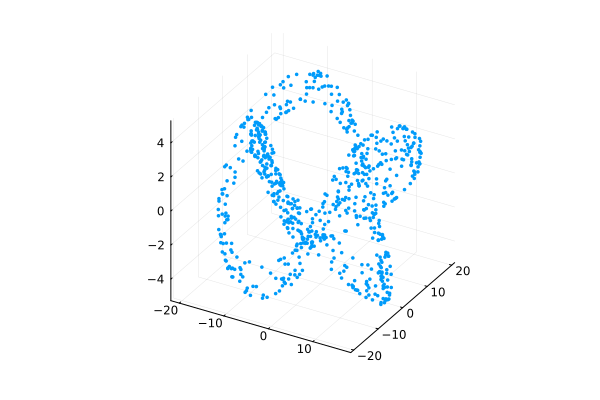

In [6]:
filename = "trefoil_2.csv"

data = [(row[1], row[2], row[3]) for row in CSV.File(filename, header=false)]

data = data[1:2:end]


x_coords = getindex.(data, 1)
y_coords = getindex.(data, 2)
z_coords = getindex.(data, 3)

data_matrix = hcat(x_coords, y_coords, z_coords)'

distance_matrix = pairwise(Euclidean(), data_matrix);

using Plots
#plotlyjs() # Sets the backend to PlotlyJS for interactive plots
x_coords = [p[1] for p in data]
y_coords = [p[2] for p in data]
z_coords = [p[3] for p in data]

scatter3d(
    x_coords, 
    y_coords, 
    z_coords,
    markersize=2,         # Adjust the size of the points
    markerstrokewidth=0,  # Removes the border from points for a cleaner look
    legend=false          # No need for a legend with only one data series
)


In [7]:
threshold_ = 5

rips = Ripserer.Rips(distance_matrix, sparse = false, threshold = threshold_)
#rips = EdgeCollapsedRips(rips)

diagram_cocycles = ripserer(rips; reps=[1], field = Ripserer.Mod{FIELD})
thresh_for_X = diagram_cocycles[2][end][2] + 1e-10

plot(diagram_cocycles)



LoadError: DomainError with 8:
modulus must be a prime number

In [8]:
most_persistent_co = diagram_cocycles[2][end]
cocycle = Ripserer.representative(most_persistent_co);
simps_co = Ripserer.vertices.(cocycle);
simps_co = simps_co[ Ripserer.birth.(cocycle) .< thresh_for_X]


LoadError: UndefVarError: `diagram_cocycles` not defined

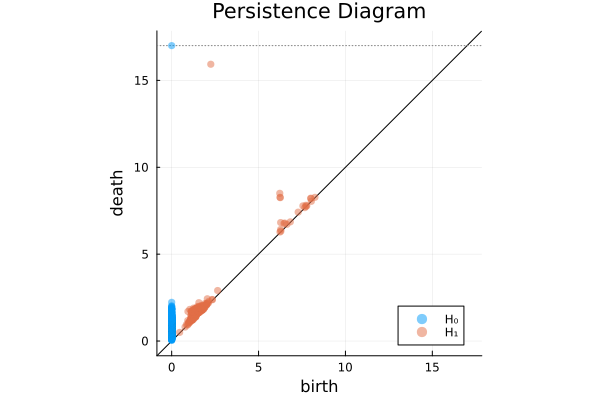

In [49]:
"""

:homology: Significantly slower than :cohomology, but finds representative cycles. Does not find infinite intervals beyond dimension 0.

:involuted: Use cohomology result to compute representative cycles. Can be extremely efficient compared to :homology, especially with Rips filtrations. See this paper for more information.

Does not seem to give correct representatives, if look at bar ending at infinity

"""

rips_ho = Ripserer.Rips(distance_matrix, sparse = false, threshold = 17)

diagram_cycles = ripserer(rips_ho; alg=:involuted, field = Ripserer.Mod{FIELD}, reps=[1])
plot(diagram_cycles)


In [50]:
most_persistent_ho = diagram_cycles[2][end]
cycle = Ripserer.representative(most_persistent_ho);
simps_ho = Ripserer.vertices.(cycle);


In [51]:
coeff_co = Ripserer.coefficient.(cocycle);
coeff_co = coeff_co*2
countmap(Int.(coeff_co))

Dict{Int64, Int64} with 4 entries:
  2  => 649
  45 => 475
  46 => 25223
  1  => 23686

In [52]:
α = Int.(coeff_co);
α[α .>= FIELD÷2] .-= FIELD;
α = Int.(α*1);
#unique(α)

In [53]:
coeff_ho = coefficient.(cycle)
coeff_ho = coeff_ho*2;
countmap(Int.(coeff_ho))

Dict{Int64, Int64} with 4 entries:
  2  => 29
  45 => 31
  46 => 108
  1  => 109

In [54]:
"""
If this prints something, we cant lift the cycle. If its quite, then its no problem
"""

verify_coefficients_indexed(simps_ho, Int.(coeff_ho), FIELD)


In [55]:
β = Int.(coeff_ho);
β[β .>= FIELD÷2] .-= FIELD;
β = 1*β;
#unique(β)

In [56]:
"""
If the sum of elts that are smaller then p-1/2 is also smaller then p-1/2, then we can Lift.
"""

"If the sum of elts that are smaller then p-1/2 is also smaller then p-1/2, then we can Lift.\n"

In [57]:
res = 0
for i in 1:length(coeff_co)
    index = findfirst(isequal(simps_co[i]), simps_ho)
    if index !== nothing
        print("Index: ", index,", Values: COHO ", α[i]," * HO ", β[index])
        res += α[i]*β[index]
    end
end
mod(res,FIELD)  # this is +-1 iff cycle & cocycle are generators from UCT for cohomology R = G = \mathbb{Z}

Index: 1, Values: COHO 2 * HO 1

2

In [58]:
"""

Exactly one of them is a generator (2 is a prime). Reduce both modulo 2 and see which one is a (co)boundary.

""";

In [59]:
"""

Compute  [alpha] neq 0 in H_1(X, Z)=Z and  [beta] neq 0 in H_1(X, Z)=Z.

Compute Kronicker paring <alpha, beta> = prod_i p_i (p_i prime factorization).

Check for all i if [alpha_{p_i}] neq 0 in H_1(X, Z/p_i)=Z/p_i.

If  [alpha_{p_i}]  is non zero for all i, then  [alpha] is a generator of H_1(X, Z).

""";

In [60]:
"""

Checking if α[i] mod p is a boundary. This is integer, cocycle. 

""";

In [61]:
@time begin
edges_X  =  Ripserer.vertices.(Ripserer.edges(rips))[birth.(Ripserer.edges(rips)) .< thresh_for_X]
D_tilde, simps_tilde, L1_dim = build_complex_and_boundary_operator(Ripserer.vertices(rips), edges_X)
end
;

 16.588430 seconds (183.03 M allocations: 8.911 GiB, 12.10% gc time, 0.69% compilation time)


In [62]:
D_tilde

5968753×5968753 SparseMatrixCSC{Int64, Int64} with 17810039 stored entries:
⎡⠙⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⎤
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

In [68]:
@time begin
multpl = 2
cocycle = cocycle[birth.(cocycle) .< thresh_for_X]
base_change_cocycle_tilde = base_change(D_tilde, cocycle, FIELD, multpl);
end;
countmap(base_change_cocycle_tilde)

 42.844934 seconds (568.36 k allocations: 45.653 MiB)


Dict{Int64, Int64} with 5 entries:
  0  => 5918720
  -1 => 25223
  2  => 649
  -2 => 475
  1  => 23686

In [69]:
base_change_cocycle_tilde

5968753-element SparseVector{Int64, Int64} with 50033 stored entries:
  [752  ]  =  -1
  [754  ]  =  -1
  [755  ]  =  -1
  [756  ]  =  -1
  [757  ]  =  -1
  [759  ]  =  -1
  [761  ]  =  -1
  [763  ]  =  -1
  [764  ]  =  -1
  [765  ]  =  -1
           ⋮
  [94696]  =  -1
  [94700]  =  -1
  [94701]  =  -1
  [94703]  =  -1
  [94704]  =  -1
  [94706]  =  -1
  [94708]  =  1
  [94711]  =  1
  [94714]  =  -1
  [94715]  =  -1
  [94716]  =  -1

In [70]:
"""

Lifting produce a coycycle?

If this is zero, then it is a cocycle

"""

transpose(D_tilde) * base_change_cocycle_tilde

5968753-element SparseVector{Int64, Int64} with 0 stored entries

  2.807683 seconds (9.82 M allocations: 200.118 MiB, 20.89% gc time)


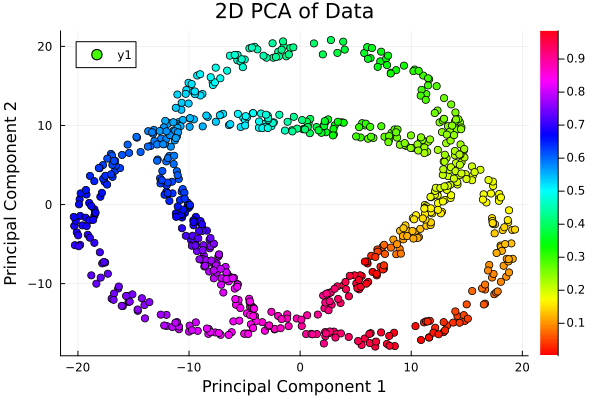

In [71]:
using IterativeSolvers
using MultivariateStats
using LinearAlgebra

@time begin
θ = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde[1:size(data)[1],1:L1_dim ]), base_change_cocycle_tilde[1:L1_dim])), 1.0);
end;

data_matrix = stack(data)

M = fit(PCA, data_matrix; maxoutdim=2, pratio=1.0)
reduced_data = MultivariateStats.transform(M, data_matrix)

scatter(reduced_data[1,:], reduced_data[2,:], zcolor = θ ,c = :hsv, 
        xlabel="Principal Component 1", 
        ylabel="Principal Component 2",
        title="2D PCA of Data")


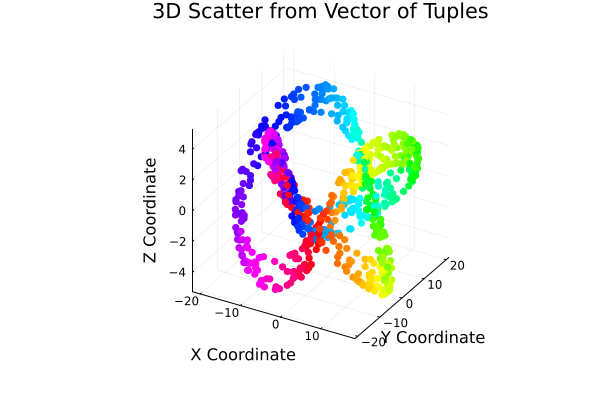

In [72]:

# --- 2. Unpack the Data for Plotting ---
# Plots.jl typically expects separate vectors for each coordinate (x, y, z).
# We can easily create these from our vector of tuples using list comprehensions.
x_coords = [point[1] for point in data]
y_coords = [point[2] for point in data]
z_coords = [point[3] for point in data]


# --- 3. Define Coloring Based on Angle (Theta) ---
# The color is determined by the angle in the XY plane.
#theta_color = atan.(y_coords, x_coords)


# --- 4. Create and Save the 3D Plot ---
# Now we use the unpacked coordinate vectors to create the scatter plot.
# The coloring is applied using zcolor and the :hsv colormap as requested.
scatter(x_coords, y_coords, z_coords,
    zcolor = θ,
    color = :hsv,
    xlabel = "X Coordinate",
    ylabel = "Y Coordinate",
    zlabel = "Z Coordinate",
    title = "3D Scatter from Vector of Tuples",
    legend = false,
    markerstrokewidth = 0,
    markersize = 4
)

#### """
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________
""";



In [73]:
multpl = 2
base_change_cocycle_tilde_2 = base_change(D_tilde, cocycle, FIELD, multpl);
base_change_cocycle_tilde_2

"""

need to check that this is not a boundary mod 2, as Kronicker pariing is 2

"""

"\nneed to check that this is not a boundary mod 2, as Kronicker pariing is 2\n\n"

In [74]:
field_to_check = 2
F = AbstractAlgebra.GF(field_to_check)

Finite field F_2

In [ ]:

"""
has order field_to_check if this is zero
"""


D_tilde_mod_F = sparse_matrix(F,Array(D_tilde[1:L1_dim, 1:L1_dim]))
    
base_change_cocycle_tilde_2_mod_F = sparse_matrix(F,Array(reshape(deepcopy(base_change_cocycle_tilde_2[1:L1_dim]),:, 1)))   
  
#cocycle = Int64.(Oscar.lift.(Array(cocycle)[1,:]))


In [113]:
size(transpose(D_tilde_mod_F)), size(transpose(base_change_cocycle_tilde_2_mod_F))

((9196, 9196), (1, 9196))

In [114]:
D_tilde_mod_F

Sparse 9196 x 9196 matrix with 17392 non-zero entries

In [115]:
"""

IF this fails to find a solution, it means that base_change_cocycle_tilde_2_mod_F is not a boundary mod field_to_check.

"""

zero_questionmark = Oscar.can_solve(transpose(D_tilde_mod_F), base_change_cocycle_tilde_2_mod_F)


false

In [116]:
transpose(D_tilde) * base_change_cocycle_tilde_2

85719-element SparseVector{Int64, Int64} with 0 stored entries

In [117]:
"""

Suppose alpha = base_change_cocycle_tilde has order n,
We want to find a generator gamma by solving

alpha = n gamma + D^0f
This can be reduced to solving Ax = alpha.
We want to do this over a finite field (to make the computations feasible), then lift to integers as before.
We must find an out when this makes the lifted stay a generator, but with computations over a big enough prime, it should be ok.

"""


order_of_alpha = 5
base_change_cocycle_tilde

85719-element SparseVector{Int64, Int64} with 39 stored entries:
  [770 ]  =  1
  [1903]  =  1
  [1908]  =  1
  [1909]  =  1
  [3629]  =  1
  [3632]  =  1
  [3637]  =  1
  [3638]  =  1
  [4619]  =  1
  [4624]  =  1
          ⋮
  [7769]  =  -1
  [7770]  =  -1
  [7772]  =  -1
  [7781]  =  1
  [7782]  =  1
  [8022]  =  1
  [8023]  =  1
  [8439]  =  1
  [8440]  =  1
  [8572]  =  -1
  [8573]  =  -1

In [118]:
big_field = 47
big_F = Oscar.ZZ#AbstractAlgebra.GF(big_field)

Integer ring

In [119]:
slice = base_change_cocycle_tilde[length(data)+1:L1_dim]
reshaped_slice = Array(reshape(base_change_cocycle_tilde[length(data)+1:L1_dim], length(slice), 1))

8696×1 Matrix{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [120]:
#α_1 = big_F.(Matrix(reshaped_slice))
α_1 = sparse_matrix(big_F, reshaped_slice)

Sparse 8696 x 1 matrix with 39 non-zero entries

In [121]:
D_0 =  sparse_matrix(big_F, Array(transpose(D_tilde)[1:L1_dim-length(data),1:L1_dim])) # edges times edges + vertecies

Sparse 8696 x 9196 matrix with 16392 non-zero entries

In [122]:
identity_matri_times_order = Oscar.sparse_matrix(identity_matrix(big_F,L1_dim-length(data)))* order_of_alpha#sparse_matrix(big_F, order_of_alpha * Array(I, L1_dim-length(data), L1_dim-length(data)))
#Oscar.identity_matrix(big_F, L1_dim-length(data))
#identity_matri_times_order = Oscar.sparse_matrix(identity_matrix(big_F,L1_dim-length(data))*order_of_alpha)

Sparse 8696 x 8696 matrix with 8696 non-zero entries

In [123]:
A = hcat(identity_matri_times_order, D_0)

Sparse 8696 x 17892 matrix with 25088 non-zero entries

In [124]:
#size(A), size(sparse_matrix(α_1))
size(A), size(α_1)

((8696, 17892), (8696, 1))

In [128]:
#_ , γ = Oscar.can_solve_with_solution(A, sparse_matrix(α_1))#, side = :left)
#_ , γ = Oscar.solve(Array(A), Array(α_1))
_ , γ = Oscar.solve(Array(A), Array(α_1))
#_ , γ = AbstractAlgebra.solve(Array(A), Array(α_1))

LoadError: MethodError: no method matching solve(::Matrix{ZZRingElem}, ::Matrix{ZZRingElem})

In [62]:
"""
In order to proceed we need that these values are liftable, as the lift would be a generator, we already know that these have to lie in {-p/3, ... ,-1, 0, 1, ..., p/3}
"""

test = unique(lift.(Array(γ)[:,1])) 
check_if_scalable_to_S(test, big_field)
mult_to_fix = 1

LoadError: UndefVarError: `γ` not defined

In [190]:
sum(Array(γ)[:,1] -  α_1[:,1]) # verifying that somethings happens 

38

In [191]:
size(γ,1) + length(data) + size(D_tilde, 1) - L1_dim

1589866

In [192]:
new_gamma = Int.([zeros(length(data)); lift.(Array(γ)[:,1] * mult_to_fix) ; zeros(size(D_tilde, 1) - L1_dim)])
unique(new_gamma)

5-element Vector{Int64}:
  0
 46
  1
 45
  2

In [64]:

new_gamma[new_gamma .>= big_field÷2] .-= big_field
new_gamma = 1*new_gamma
unique(new_gamma), size(new_gamma)

LoadError: UndefVarError: `new_gamma` not defined

In [65]:
size(Array(γ)), size(sparse_matrix(α_1) ), size(base_change_cocycle_tilde)

LoadError: UndefVarError: `γ` not defined

In [66]:
using IterativeSolvers
using MultivariateStats
using LinearAlgebra

θ = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde), new_gamma)[1:size(data,1)]), 1.0);


data_matrix = stack(data)

M = fit(PCA, data_matrix; maxoutdim=2, pratio=1.0)
reduced_data = MultivariateStats.transform(M, data_matrix)

scatter(reduced_data[1,:], reduced_data[2,:], zcolor = θ ,c = :viridis, 
        xlabel="Principal Component 1", 
        ylabel="Principal Component 2",
        title="2D PCA of Data")


LoadError: UndefVarError: `new_gamma` not defined

In [161]:
unique(base_change_cocycle_tilde)

2-element Vector{Int64}:
 0
 1

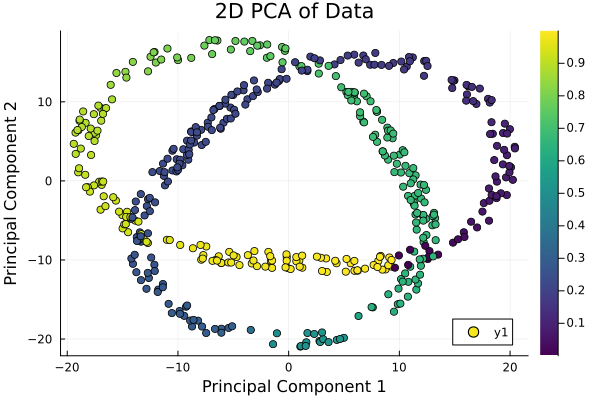

In [254]:
using IterativeSolvers
using MultivariateStats
using LinearAlgebra

θ = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde), base_change_cocycle_tilde)[1:size(data,1)]), 1.0);


data_matrix = stack(data)

M = fit(PCA, data_matrix; maxoutdim=2, pratio=1.0)
reduced_data = MultivariateStats.transform(M, data_matrix)

scatter(reduced_data[1,:], reduced_data[2,:], zcolor = θ ,c = :viridis, 
        xlabel="Principal Component 1", 
        ylabel="Principal Component 2",
        title="2D PCA of Data")


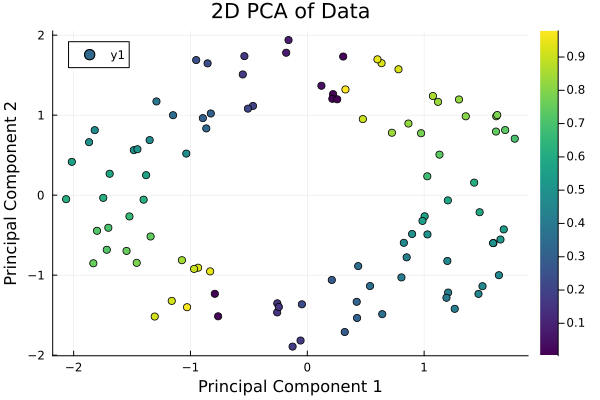

In [92]:
using IterativeSolvers
using MultivariateStats
using LinearAlgebra

θ = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde), base_change_cocycle_tilde_2)[1:size(data,1)]), 1.0);


data_matrix = stack(data)

M = fit(PCA, data_matrix; maxoutdim=2, pratio=1.0)
reduced_data = MultivariateStats.transform(M, data_matrix)

scatter(reduced_data[1,:], reduced_data[2,:], zcolor = θ ,c = :viridis, 
        xlabel="Principal Component 1", 
        ylabel="Principal Component 2",
        title="2D PCA of Data")

In [394]:
"""θ = Array(IterativeSolvers.lsmr(transpose(D), cocycle_in_basis)[1:size(data,1)])
θ .-= minimum(θ)
θ ./ maximum(θ)
This works still??
""";

In [320]:
"""
Check if boundary...
"""

"Check if boundary...\n"

In [31]:
"""

solve Dx  = cocycle_in_basis
mod p

"""

"\nsolve Dx  = cocycle_in_basis\nmod p\n\n"

In [32]:
cocycle_in_basis_F = sparse_matrix(F,Array(reshape(cocycle_in_basis, :, 1)))   

LoadError: UndefVarError: `F` not defined

In [1723]:
D_F = sparse_matrix(F, Array(D[1:500,:]))

Sparse 500 x 6301 matrix with 5337 non-zero entries

In [1724]:
size(D_F), size(cocycle_in_basis_F)

((500, 6301), (6301, 1))

In [1725]:
using Oscar 
  
solution = Oscar.solve(transpose(D_F), transpose(cocycle_in_basis_F))

LoadError: AssertionError: fl

In [1726]:
"""

Circ_coords

"""

"\nCirc_coords\n\n"